In [27]:
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import confusion_matrix, f1_score, recall_score

from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
path = Path.cwd().parents[0] / 'output/vote_result.xlsx'
df = pd.read_excel(path)

In [29]:
def preprocess_df(df):
    return (df
        .drop(columns='nama')
    )

df_clean = preprocess_df(df)

NUM_COLS = ['vote', 'no_urut', 'partai_vote']
CAT_COLS = ['dapil_no', 'dapil_nama', 'partai']
TARGET = ['terpilih']

assert sorted(NUM_COLS + CAT_COLS + TARGET) == sorted(df_clean.columns)

x = df_clean[NUM_COLS + CAT_COLS]
y = df_clean[TARGET]

# First Try

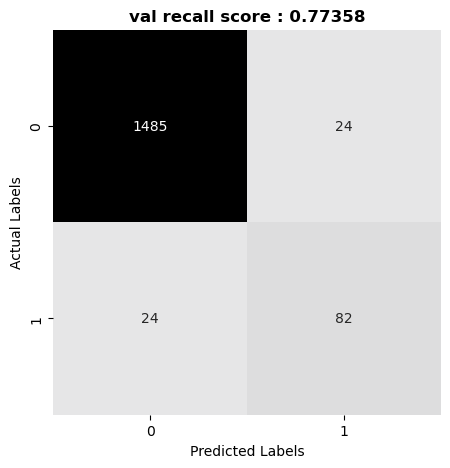

In [37]:
# preprocessing pipeline
numerical_pipe = Pipeline([
    ('scale', StandardScaler())
])
categorical_pipe = Pipeline([
    ('encode', OneHotEncoder(sparse_output=False)), 
    ('scale', StandardScaler())
])
pipe = ColumnTransformer([
    ("numerical", numerical_pipe, NUM_COLS),
    ("categorical", categorical_pipe, CAT_COLS)
])

# prediction pipeline
prediction= Pipeline([
    ('model', XGBClassifier())
])

# full pipeline
pipeline= Pipeline([
    ('preprocessing', pipe),
    ('prediction', prediction)
])

# fold
fold= StratifiedKFold(
    n_splits= 5, 
    shuffle= True, 
    random_state= 8
)

# training
y_pred= cross_val_predict(
    estimator = pipeline, 
    cv= fold, 
    X= x, 
    y= y, 
    n_jobs= -1, 
    verbose= 0
)

# confusion matrix
val_score = recall_score(y, y_pred)
cm = confusion_matrix(y, 
                      y_pred, 
                    #   normalize='true'
                      )

plt.figure(figsize=(5, 5))
cmap = sns.cubehelix_palette(50, hue=0.05, rot=0, light=0.9, dark=0, as_cmap=True)
sns.heatmap(cm, annot=True, cmap=cmap, cbar=False, fmt='.0f')

plt.title(f'val recall score : {val_score:.5f}', fontweight='bold')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')

plt.show()

# HP Tuning

In [36]:
import numpy as np
import optuna

import sklearn.datasets
import sklearn.metrics
from sklearn.model_selection import train_test_split
import xgboost as xgb


def objective(trial):

    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        # use exact for small dataset.
        "tree_method": "exact",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    # preprocessing pipeline
    numerical_pipe = Pipeline([
        ('scale', StandardScaler())
    ])
    categorical_pipe = Pipeline([
        ('encode', OneHotEncoder(sparse_output=False)), 
        ('scale', StandardScaler())
    ])
    pipe = ColumnTransformer([
        ("numerical", numerical_pipe, NUM_COLS),
        ("categorical", categorical_pipe, CAT_COLS)
    ])

    # prediction pipeline
    prediction= Pipeline([
        ('model', XGBClassifier(**param))
    ])

    # full pipeline
    pipeline= Pipeline([
        ('preprocessing', pipe),
        ('prediction', prediction)
    ])

    # fold
    fold= StratifiedKFold(
        n_splits= 5, 
        shuffle= True, 
        random_state= 8
    )
    
    # training
    y_pred= cross_val_predict(
        estimator = pipeline, 
        cv= fold, 
        X= x, 
        y= y, 
        n_jobs= -1, 
        verbose= 0
    )
    
    val_recall_score = recall_score(y, y_pred)
    return val_recall_score


if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100, timeout=600)

    print("Number of finished trials: ", len(study.trials))
    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2023-09-04 19:15:45,860] A new study created in memory with name: no-name-442bd88e-2301-4cad-9153-be80cf89c090
[I 2023-09-04 19:15:46,432] Trial 0 finished with value: 0.7358490566037735 and parameters: {'booster': 'dart', 'lambda': 5.601441880267421e-07, 'alpha': 0.005318868324778439, 'subsample': 0.45251249485498485, 'colsample_bytree': 0.8613767126055805, 'max_depth': 7, 'min_child_weight': 8, 'eta': 0.3669762445479588, 'gamma': 0.2746520555218708, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.00022228423579127773, 'skip_drop': 0.9183189880954469}. Best is trial 0 with value: 0.7358490566037735.
[I 2023-09-04 19:15:46,540] Trial 1 finished with value: 0.7264150943396226 and parameters: {'booster': 'gblinear', 'lambda': 4.65998965909137e-08, 'alpha': 5.01863014604082e-05, 'subsample': 0.2309234069054843, 'colsample_bytree': 0.9464611283646418}. Best is trial 0 with value: 0.7358490566037735.
[I 2023-09-04 19:15:47,073] Trial 2 fi

Number of finished trials:  100
Best trial:
  Value: 0.8679245283018868
  Params: 
    booster: gbtree
    lambda: 7.056615409364689e-07
    alpha: 5.734641960855347e-05
    subsample: 0.31290608315067053
    colsample_bytree: 0.9840924449327544
    max_depth: 3
    min_child_weight: 10
    eta: 2.9900993036801438e-05
    gamma: 0.10414040522001804
    grow_policy: depthwise


In [42]:
trial.params

{'booster': 'gbtree',
 'lambda': 7.056615409364689e-07,
 'alpha': 5.734641960855347e-05,
 'subsample': 0.31290608315067053,
 'colsample_bytree': 0.9840924449327544,
 'max_depth': 3,
 'min_child_weight': 10,
 'eta': 2.9900993036801438e-05,
 'gamma': 0.10414040522001804,
 'grow_policy': 'depthwise'}

# Try with Tuned HP

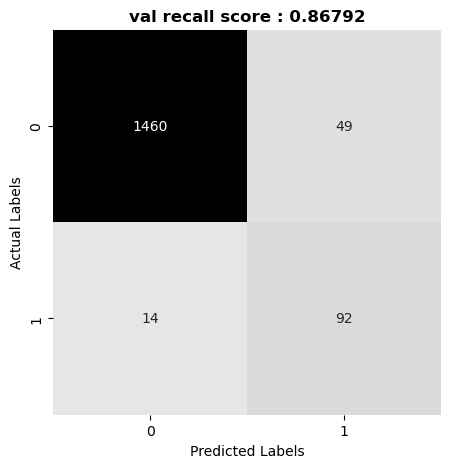

In [44]:
# preprocessing pipeline
numerical_pipe = Pipeline([
    ('scale', StandardScaler())
])
categorical_pipe = Pipeline([
    ('encode', OneHotEncoder(sparse_output=False)), 
    ('scale', StandardScaler())
])
pipe = ColumnTransformer([
    ("numerical", numerical_pipe, NUM_COLS),
    ("categorical", categorical_pipe, CAT_COLS)
])

# prediction pipeline
prediction= Pipeline([
    ('model', XGBClassifier(**trial.params))
])

# full pipeline
pipeline= Pipeline([
    ('preprocessing', pipe),
    ('prediction', prediction)
])

# fold
fold= StratifiedKFold(
    n_splits= 5, 
    shuffle= True, 
    random_state= 8
)

# training
y_pred= cross_val_predict(
    estimator = pipeline, 
    cv= fold, 
    X= x, 
    y= y, 
    n_jobs= -1, 
    verbose= 0
)

# confusion matrix
val_score = recall_score(y, y_pred)
cm = confusion_matrix(y, 
                      y_pred, 
                    #   normalize='true'
                      )

plt.figure(figsize=(5, 5))
cmap = sns.cubehelix_palette(50, hue=0.05, rot=0, light=0.9, dark=0, as_cmap=True)
sns.heatmap(cm, annot=True, cmap=cmap, cbar=False, fmt='.0f')

plt.title(f'val recall score : {val_score:.5f}', fontweight='bold')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')

plt.show()